In [0]:
# target
target = 'horse'

# hyper params
EPOCHS = (1000, 1000, 1000, 700, 400, 400)
BATCH_SIZES = (64, 64, 64, 32, 16, 8)
initial_scale = 1.
GPU = 0

# extension params
log_interval = 10
display_interval = 100
tweet_interval = 100
snapshot_interval = 100

# model params
sa_gamma = 1
gen_noise = 5e-2
SCALEUP_ALPHA = 0.5
START = 0
IMG_SIZE = 256
LATENT_SIZE = 256

# learning controller
learning_rate = 1e-4
grad_clip = None
gen_weight_decay = 0
dis_weight_decay = 0
sa_endpoint = 500
sg_endpoint = 200

# file names
load_weight = None

mount = '.'
OUT = '{}/Drive_sync/result/'.format(mount)
dataroot = '{}/Drive_sync/picture/torch_dataset'.format(mount)

gen_name = '{}_gen'.format(target)
dis_name = '{}_dis'.format(target)

In [0]:
import numpy as np
import io
import uuid
import tweepy

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import spectral_norm, clip_grad_norm_
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms

import twitter_api_key

In [0]:
def gaussian(size):
    return torch.normal(torch.zeros(size), torch.ones(size))

def zeropad(x, ch):
    return F.pad(x, (0, 0, 0, 0, 0, ch-x.size(1), 0, 0))

def gap(x):
    return F.avg_pooling2d(x, x.size()[-2:])

def noise_injection(x, k):
    return torch.normal(x, instance_var(x)*k)

def instance_var(x):
    _shape = x.size()
    _x = x.view(_shape[0], _shape[1], -1)
    _x = torch.var(_x, dim=2)
    _x = _x.view(*_x.size(), 1, 1)
    _x = _x.expand(*_shape)
    return _x

def layer_shuffle(x):
    _x = x.view(x.size(0), -1, 8, *x.size()[-2:])
    _x = torch.transpose(_x, 1,  2)
    _x = _x.reshape(*x.size())
    return _x

In [0]:
class SNConv(nn.Module):
    def __init__(self, in_ch, out_ch, kernel=1, stride=1, padding=0):
        super(SNConv, self).__init__()
        self.main = nn.Sequential(
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Conv2d(in_ch, out_ch, kernel, stride, padding))
        )
    
    def forward(self, x):
        return self.main(x)

In [0]:
class SNDense(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(SNDense, self).__init__()
        self.main = nn.Sequential(
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Linear(in_ch, out_ch))
        )

    def forward(self, x):
        return self.main(x)

In [0]:
class SNInceptionBlock(nn.Module):
    def __init__(self, in_ch, mid_ch):
        super(SNInceptionBlock, self).__init__()

        self.layer_11 = SNConv(in_ch, mid_ch)
        self.layer_33 = SNConv(in_ch, mid_ch*2, 3, 1, 1)
        self.layer_55 = SNConv(in_ch, mid_ch*2, 5, 1, 2)
        self.layer_77 = SNConv(in_ch, mid_ch*3, 7, 1, 3)
            
    def forward(self, x):
        h_11 = self.layer_11(x)
        h_33 = self.layer_33(x)
        h_55 = self.layer_55(x)
        h_77 = self.layer_77(x)
        
        h = torch.cat((h_11, h_33, h_55, h_77), dim=1)
        return h

In [0]:
class SelfAttentionBlock(nn.Module):
    def __init__(self, in_ch, out_ch, gamma=1.):
        super(SelfAttentionBlock, self).__init__()

        self.gamma = gamma
        self.cf = SNConv(in_ch, out_ch//8)
        self.cg = SNConv(in_ch, out_ch//8)
        self.ch = SNConv(in_ch, out_ch)
        self.softmax = nn.Softmax(2)
            
    def forward(self, x):
        f = self.cf(x)
        g = self.cg(x)
        h = self.ch(x)
        f = f.view(f.size(0), f.size(1), -1)
        g = g.view(g.size(0), g.size(1), -1)
        h = h.view(h.size(0), h.size(1), -1)
        
        attention_map = torch.bmm(torch.transpose(f, 1, 2), g)
        attention_map = self.softmax(attention_map)
        feature_map = torch.bmm(h, torch.transpose(attention_map, 1, 2))
        feature_map = feature_map.view(*x.size())

        return x + feature_map*self.gamma

    def set_gamma(self, gamma):
        self.gamma = gamma

In [0]:
class MinibatchDiscrimination(nn.Module):
    def __init__(self, kernel, in_ch, kernel_dims, device):
        super(MinibatchDiscrimination, self).__init__()
        self.device = device
        self.kernel = kernel
        self.dim = kernel_dims
        self.t = spectral_norm(nn.Linear(in_ch, self.kernel*self.dim))

    def __call__(self, x):
        batchsize = x.size(0)
        m = self.t(x).view(batchsize, self.kernel, self.dim, 1)
        m_T = torch.transpose(m, 0, 3)
        m, m_T = torch.broadcast_tensors(m, m_T)
        norm = torch.sum(F.l1_loss(m, m_T, reduction='none'), dim=2)

        eraser = torch.eye(batchsize, device=self.device).view(batchsize, 1, batchsize).expand(norm.size())
        c_b = torch.exp(-(norm + 1e6 * eraser))
        o_b = torch.sum(c_b, dim=2)
        h = torch.cat((x, o_b), dim=1)
        return h

In [0]:
class Discriminator(nn.Module):

    def __init__(self, out_ch=2, alpha=0.5, device=None, sa_gamma=1.):
        super(Discriminator, self).__init__()
        self.alpha = alpha

        self.in_256 = spectral_norm(nn.Conv2d(3, 32, 1, 1, 0))
        self.layer_256 = nn.Sequential(
            SNInceptionBlock(32, 4),
            SNConv(32, 64, 4, 2, 1)
        )

        self.in_128 = spectral_norm(nn.Conv2d(3, 64, 1, 1, 0))
        self.layer_128 = nn.Sequential(
            SNInceptionBlock(64, 8),
            SNConv(64, 128, 4, 2, 1)
        )

        self.in_64 = spectral_norm(nn.Conv2d(3, 128, 1, 1, 0))
        self.layer_64 = nn.Sequential(
            SNInceptionBlock(128, 16),
            SNConv(128, 256, 4, 2, 1)
        )

        self.in_32 = spectral_norm(nn.Conv2d(3, 256, 1, 1, 0))
        self.layer_32 = nn.Sequential(
            SNInceptionBlock(256, 32),
            SNConv(256, 512, 4, 2, 1)
        )

        self.in_16 = spectral_norm(nn.Conv2d(3, 512, 1, 1, 0))
        self.layer_16 = nn.Sequential(
            SNInceptionBlock(512, 64),
            SelfAttentionBlock(512, 512, gamma=sa_gamma),
            SNConv(512, 512, 4, 2, 1)
        )

        self.in_8 =  spectral_norm(nn.Conv2d(3, 512, 1, 1, 0))
        self.layer_8 = nn.Sequential(
            SNInceptionBlock(512, 64),
            SelfAttentionBlock(512, 512, gamma=sa_gamma),
            nn.AvgPool2d(8),
            nn.Flatten(),
            MinibatchDiscrimination(64, 512, 16, device),
            SNDense(512+64, out_ch)
        )
    
    def forward(self, x, img_size, delta=None):

        if img_size >= 256:
            h = self.in_256(x)
            h = self.layer_256(h)
        else:
            h = 0
        
        if img_size >= 128:
            _x = F.avg_pool2d(x, img_size//128)
            if img_size == 128:
                h = h + self.in_128(_x)
            elif delta and img_size == 256:
                h = delta * h + (1-delta) * self.in_128(_x)
            else:
                h = self.alpha * h + (1-self.alpha) * self.in_128(_x)
            h = self.layer_128(h)
        
        if img_size >= 64:
            _x = F.avg_pool2d(x, img_size//64)
            if img_size == 64:
                h = h + self.in_64(_x)
            elif delta and img_size == 128:
                h = delta * h + (1-delta) * self.in_64(_x)
            else:
                h = self.alpha * h + (1-self.alpha) * self.in_64(_x)
            h = self.layer_64(h)
        
        if img_size >= 32:
            _x = F.avg_pool2d(x, img_size//32)
            if img_size == 32:
                h = h + self.in_32(_x)
            elif delta and img_size == 64:
                h = delta * h + (1-delta) *  self.in_32(_x)
            else:
                h = self.alpha * h + (1-self.alpha) * self.in_32(_x)
            h = self.layer_32(h)
        
        if img_size >= 16:
            _x = F.avg_pool2d(x, img_size//16)
            if img_size == 16:
                h = h + self.in_16(_x)
            elif delta and img_size == 32:
                h = delta * h + (1-delta) * self.in_16(_x)
            else:
                h = self.alpha * h + (1-self.alpha) * self.in_16(_x)
            h = self.layer_16(h)

        _x = F.avg_pool2d(x, img_size//8)
        if img_size == 8:
            h = h + self.in_8(_x)
        elif delta and img_size == 16:
            h = delta * h + (1-delta) * self.in_8(_x)
        else:
            h = self.alpha * h + (1-self.alpha) * self.in_8(_x)
        h = self.layer_8(h)
        return h

    def set_gamma(self, gamma, img_size):
        if img_size == 8:
            self.layer_8[1].set_gamma(gamma)
        if img_size == 16:
            self.layer_16[1].set_gamma(gamma)

In [0]:
class Conv(nn.Module):
    def __init__(self, in_ch, out_ch, kernel=1, stride=1, padding=0):
        super(Conv, self).__init__()
        self.main = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_ch, out_ch, kernel, stride, padding),
            nn.BatchNorm2d(out_ch)
        )
    
    def forward(self, x):
        return self.main(x)

In [0]:
class Dense(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Dense, self).__init__()
        self.main = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Linear(in_ch, out_ch)
        )

    def forward(self, x):
        return self.main(x)

In [0]:
class Affine(nn.Module):
    def __init__(self, in_ch, mid_ch=64, w_ch=128):
        super(Affine, self).__init__()
        
        self.main = nn.Sequential(
            Dense(in_ch, mid_ch),
            Dense(mid_ch, mid_ch),
            Dense(mid_ch, mid_ch),
            Dense(mid_ch, mid_ch),
            Dense(mid_ch, mid_ch),
            Dense(mid_ch, mid_ch),
            Dense(mid_ch, mid_ch),
            Dense(mid_ch, w_ch)
        )

    def forward(self, x):
        return self.main(x)

In [0]:
class AdaIN(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(AdaIN, self).__init__()

        self.average_convert = Dense(in_ch, out_ch)
        self.bias_convert = Dense(in_ch, out_ch)

    def forward(self, x, w):
        h = F.instance_norm(x)
        a = self.average_convert(w)
        a = a.view(*a.size(), 1, 1).expand(*h.size())
        b = self.bias_convert(w)
        b = b.view(*b.size(), 1, 1).expand(*h.size())
        return h * a + b

In [0]:
class InceptionBlock(nn.Module):
    def __init__(self, in_ch, mid_ch):
        super(InceptionBlock, self).__init__()

        self.layer_11 = Conv(in_ch, mid_ch)
        self.layer_33 = Conv(in_ch, mid_ch*2, 3, 1, 1)
        self.layer_55 = Conv(in_ch, mid_ch*2, 5, 1, 2)
        self.layer_77 = Conv(in_ch, mid_ch*3, 7, 1, 3)
            
    def forward(self, x):
        h_11 = self.layer_11(x)
        h_33 = self.layer_33(x)
        h_55 = self.layer_55(x)
        h_77 = self.layer_77(x)
        
        h = torch.cat((h_11, h_33, h_55, h_77), dim=1)
        return h

In [0]:
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, latent_w):
        super(ResBlock, self).__init__()
        self.ch_1 = in_ch*3//2
        self.ch_2 = in_ch*2

        self.inception_1 = InceptionBlock(in_ch, in_ch*3//16)
        self.adain_1 = AdaIN(latent_w, self.ch_1)

        self.inception_2 = InceptionBlock(self.ch_1, in_ch//4)
        self.adain_2 = AdaIN(latent_w, self.ch_2)

        self.c = Conv(self.ch_2, out_ch)
        self.c_out = Conv(self.ch_2, 3)
            
    def forward(self, x, w1, w2, noise=None):
        _h = noise_injection(x, noise) if noise else x
        _h = self.inception_1(_h)
        _h = layer_shuffle(_h)
        h = zeropad(x, self.ch_1)
        h = h + _h
        h = self.adain_1(h, w1)

        _h = noise_injection(h, noise) if noise else h
        _h = self.inception_2(_h)
        _h = layer_shuffle(_h)
        h = zeropad(h, self.ch_2)
        h = h + _h
        _h = self.adain_2(h, w1)

        h = self.c(_h)
        out = self.c_out(_h)
        return h, out

In [0]:
class Generator(nn.Module):

    def __init__(self, latent_size, alpha=0.5, noise=None, device=None):
        super(Generator, self).__init__()
        self.noise = noise
        self.device = device
        self.alpha = alpha
        self.latent_size = latent_size

        self.btm = nn.Linear(self.latent_size, 512*8*8)
        self.affine = Affine(self.latent_size, self.latent_size, self.latent_size)
        
        self.res5 = ResBlock(512, 512, self.latent_size)
        self.res4 = ResBlock(512, 256, self.latent_size)
        self.res3 = ResBlock(256, 128, self.latent_size)
        self.res2 = ResBlock(128, 64, self.latent_size)
        self.res1 = ResBlock(64, 32, self.latent_size)
        self.res0 = ResBlock(32, 16, self.latent_size)

        self.upbi = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
    
    def forward(self, x, img_size, delta=None):
        h = self.affine(x)
        h = self.btm(h).view(-1, 512, 8, 8)
        w1 = self.affine(gaussian((x.size(0), self.latent_size)).to(self.device))
        w2 = self.affine(gaussian((x.size(0), self.latent_size)).to(self.device))
        h, out = self.res5(h, w1, w2, self.noise)
        
        if img_size >= 16:
            h = self.upbi(h)
            w1 = self.affine(gaussian((x.size(0), self.latent_size)).to(self.device))
            w2 = self.affine(gaussian((x.size(0), self.latent_size)).to(self.device))
            h, _out = self.res4(h, w1, w2, self.noise)
            if delta and img_size == 16:
                out = (1-delta) * self.upbi(out) + delta * _out
            else:
                out = (1-self.alpha) * self.upbi(out) + self.alpha * _out
        
        if img_size >= 32:
            h = self.upbi(h)
            w1 = self.affine(gaussian((x.size(0), self.latent_size)).to(self.device))
            w2 = self.affine(gaussian((x.size(0), self.latent_size)).to(self.device))
            h, _out = self.res3(h, w1, w2, self.noise)
            if delta and img_size == 32:
                out = (1-delta) * self.upbi(out) + delta * _out
            else:
                out = (1-self.alpha) * self.upbi(out) + self.alpha * _out
        
        if img_size >= 64:
            h = self.upbi(h)
            w1 = self.affine(gaussian((x.size(0), self.latent_size)).to(self.device))
            w2 = self.affine(gaussian((x.size(0), self.latent_size)).to(self.device))
            h, _out = self.res2(h, w1, w2, self.noise)
            if delta and img_size == 64:
                out = (1-delta) * self.upbi(out) + delta * _out
            else:
                out = (1-self.alpha) * self.upbi(out) + self.alpha * _out
        
        if img_size >= 128:
            h = self.upbi(h)
            w1 = self.affine(gaussian((x.size(0), self.latent_size)).to(self.device))
            w2 = self.affine(gaussian((x.size(0), self.latent_size)).to(self.device))
            h, _out = self.res1(h, w1, w2, self.noise)
            if delta and img_size == 128:
                out = (1-delta) * self.upbi(out) + delta * _out
            else:
                out = (1-self.alpha) * self.upbi(out) + self.alpha * _out
        
        if img_size >= 256:
            h = self.upbi(h)
            w1 = self.affine(gaussian((x.size(0), self.latent_size)).to(self.device))
            w2 = self.affine(gaussian((x.size(0), self.latent_size)).to(self.device))
            h, _out = self.res0(h, w1, w2, self.noise)
            if delta and img_size == 256:
                out = (1-delta) * self.upbi(out) + delta * _out
            else:
                out = (1-self.alpha) * self.upbi(out) + self.alpha * _out

        return F.tanh(out)

In [0]:
device = torch.device("cuda:{}".format(GPU))

In [0]:
def weights_init(m):
    if type(m) in (nn.Linear, nn.Conv2d):
        nn.init.xavier_normal_(m.weight, gain=initial_scale)
        m.bias.data.fill_(0)
    elif type(m) == nn.BatchNorm2d:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
gen = Generator(LATENT_SIZE, alpha=SCALEUP_ALPHA, noise=gen_noise, device=device)
dis = Discriminator(out_ch=1, alpha=SCALEUP_ALPHA, device=device, sa_gamma=sa_gamma)

if load_weight:
    gen.load_state_dict(torch.load(OUT+'{}_{}px_{}epoch.pkl'.format(gen_name, *load_weight)))
    gen.eval()
    dis.load_state_dict(torch.load(OUT+'{}_{}px_{}epoch.pkl'.format(dis_name, *load_weight)))
    dis.eval()
else:
    gen.apply(weights_init)
    dis.apply(weights_init)

gen.to(device)
dis.to(device)

In [0]:
opt_gen = optim.Adam(
    gen.parameters(),
    lr=learning_rate,
    betas=(0.5, 0.999),
    weight_decay=gen_weight_decay
    )
opt_dis = optim.Adam(
    dis.parameters(),
    lr=learning_rate,
    betas=(0.5, 0.999),
    weight_decay=dis_weight_decay
    )

In [0]:
gen_losses = list()
dis_losses = list()

In [0]:
if tweet_interval:
    auth = tweepy.OAuthHandler(twitter_api_key.CONSUMER_KEY, twitter_api_key.CONSUMER_SECRET)
    auth.set_access_token(twitter_api_key.ACCESS_TOKEN_KEY, twitter_api_key.ACCESS_TOKEN_SECRET)
    api = tweepy.API(auth)

In [0]:
def report_log(i, epoch, g_loss, d_loss, g_mean, d_real_mean, d_fake_mean):
    print('[{}/{}]\tLoss_D: {:.4f}\tLoss_G: {:.4f}\tD(x): {:.4f}\tD(G(z)): {:.4f}/{:.4f}'.format(
        i, epoch, d_loss, g_loss, d_real_mean, d_fake_mean, g_mean
    ))
    gen_losses.append(g_loss)
    dis_losses.append(d_loss)

In [0]:
def make_image(gen, img_size, delta, device):
    clear_output()
    with torch.no_grad():
        generated = gen(gaussian((8, LATENT_SIZE)).to(device), img_size, delta).detach().cpu()
    generated = np.transpose(np.reshape(generated, (-1, 3, img_size, img_size)), (0, 2, 3, 1))

    plt.figure(figsize=(16, 8))
        
    for i, img in enumerate(generated):
        plt.subplot(2, 4, i+1).axis('off')
        plt.subplot(2, 4, i+1).imshow(Image.fromarray(np.uint8((img+1.)/2. *255.)))

    plt.show()

In [0]:
def image_upload(image_array, api):
    bin_io = io.BytesIO()
    img = Image.fromarray(np.uint8((image_array+1.)/2. *255.))
    img = img.resize((256, 256))
    img.save(bin_io, format='JPEG')
    result = api.media_upload(filename='{}_generated_{}.jpg'.format(target, uuid.uuid4()), file=bin_io)
    return result.media_id

In [0]:
def post_image(gen, api, img_size, epoch, delta, device):
    with torch.no_grad():
        generated = gen(gaussian((4, LATENT_SIZE)).to(device), img_size, delta).detach().cpu()
    generated = np.transpose(np.reshape(generated, (-1, 3, img_size, img_size)), (0, 2, 3, 1))

    try:
        img_ids = [image_upload(img, api) for img in generated]
        hash_tags = ['AIでペガサスを作る',
                    'epoch: {}'.format(epoch),
                    '#makeing{}'.format(target),
                    '#nowlearning...',
                    '#AI',
                    '#人工知能',
                    '#DeepLearning',
                    '#GAN']

        api.update_status(
            status='\n'.join(hash_tags),
            media_ids=img_ids
            )
    except:
        pass

In [0]:
def save_model(gen, dis, img_size, epoch):
    torch.save(gen.state_dict(), OUT+'{}_{}px_{}epoch.pkl'.format(gen_name, img_size, epoch))
    torch.save(dis.state_dict(), OUT+'{}_{}px_{}epoch.pkl'.format(dis_name, img_size, epoch))

In [0]:
def report_result():
    plt.figure(figsize=(16, 8))
    plt.plot(gen_losses,label="G")
    plt.plot(dis_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [0]:
def round_dataset(gen, dis, opt_gen, opt_dis, dataloader, img_size, delta, device):
    loss_fun = nn.MSELoss()
    for i, data in enumerate(dataloader, 0):
        dis.zero_grad()
        x_real = data[0].to(device)
        b_size = x_real.size(0)
        y_real = dis(x_real, img_size, delta).view(-1)
        real_loss = loss_fun(y_real, torch.ones(*y_real.size(), device=device))
        real_loss.backward()

        x_fake = gen(gaussian((b_size, LATENT_SIZE)).to(device), img_size, delta)
        y_fake = dis(x_fake.detach(), img_size, delta).view(-1)
        fake_loss = loss_fun(y_fake, torch.zeros(*y_fake.size(), device=device))
        fake_loss.backward()

        if grad_clip:
            clip_grad_norm_(dis.parameters(), grad_clip)
        dis_loss = real_loss + fake_loss
        opt_dis.step()
        
        gen.zero_grad()
        y_gen = dis(x_fake, img_size, delta).view(-1)
        gen_loss = loss_fun(y_gen, torch.ones(*y_gen.size(), device=device))
        gen_loss.backward()

        if grad_clip:
            clip_grad_norm_(gen.parameters(), grad_clip)
        opt_gen.step()

    return gen_loss.item(), dis_loss.item(), y_gen.mean().item(), y_real.mean().item(), y_fake.mean().item()

In [0]:
def train_loop(gen, dis, opt_gen, opt_dis, dataloader, epoch, img_size, device):
    for i in range(epoch):
        if img_size <= 16 and i <= sa_endpoint:
            gamma = sa_gamma*i/sa_endpoint
            dis.set_gamma(gamma, img_size)

        if i <= sg_endpoint:
            delta = SCALEUP_ALPHA*i/sg_endpoint
            delta = delta if delta != 0 else 1e-6
        else:
            delta = None

        log = round_dataset(gen, dis, opt_gen, opt_dis, dataloader, img_size, delta, device)

        if i % display_interval == 0:
            make_image(gen, img_size, delta, device)

        if i % log_interval == 0:
            report_log(i, epoch, *log)

        if tweet_interval and i % tweet_interval == 0:
            post_image(gen, api, img_size, i, delta, device)
        
        if snapshot_interval and i % snapshot_interval == 0:
            save_model(gen, dis, img_size, i)

In [0]:
def upscaling(gen, dis, opt_gen, opt_dis, device):
    img_size = 8*2**START
    for epoch, batch_size in zip(EPOCHS[START:], BATCH_SIZES[START:]):
        dataset = dset.ImageFolder(root=dataroot,
                                   transform=transforms.Compose([
                                                                 transforms.Resize(img_size),
                                                                 transforms.CenterCrop(img_size),
                                                                 transforms.RandomHorizontalFlip(),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                                                 ]))
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        train_loop(gen, dis, opt_gen, opt_dis, dataloader, epoch, img_size, device)
        img_size = img_size*2
    report_result()

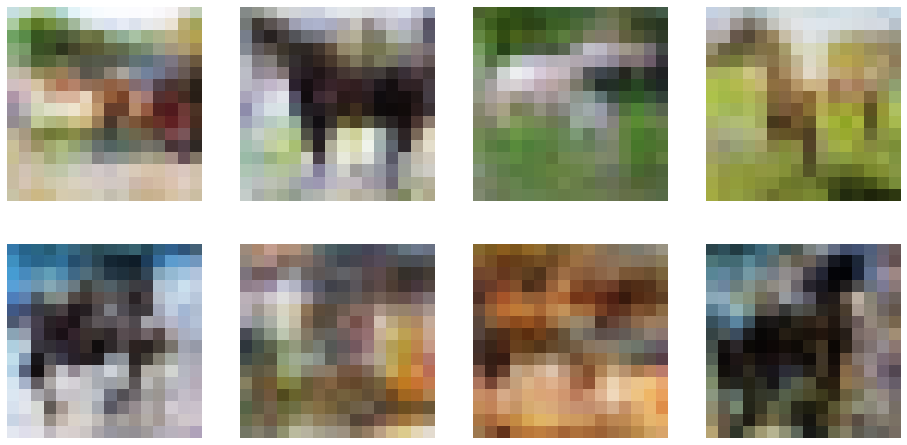

[200/1000]	Loss_D: 0.3905	Loss_G: 0.3789	D(x): 0.6580	D(G(z)): 0.4811/0.4131
[210/1000]	Loss_D: 0.2854	Loss_G: 0.4110	D(x): 0.6388	D(G(z)): 0.3649/0.3701
[220/1000]	Loss_D: 0.3288	Loss_G: 0.6152	D(x): 0.4980	D(G(z)): 0.2329/0.2258
[230/1000]	Loss_D: 0.3370	Loss_G: 0.5138	D(x): 0.5497	D(G(z)): 0.3248/0.2975
[240/1000]	Loss_D: 0.3313	Loss_G: 0.4366	D(x): 0.6507	D(G(z)): 0.4260/0.3530
[250/1000]	Loss_D: 0.3175	Loss_G: 0.4855	D(x): 0.5708	D(G(z)): 0.3311/0.3128
[260/1000]	Loss_D: 0.2824	Loss_G: 0.6085	D(x): 0.5577	D(G(z)): 0.2511/0.2311
[270/1000]	Loss_D: 0.3088	Loss_G: 0.4355	D(x): 0.6618	D(G(z)): 0.4263/0.3469
[280/1000]	Loss_D: 0.3435	Loss_G: 0.4007	D(x): 0.5723	D(G(z)): 0.3618/0.3724


In [0]:
upscaling(gen, dis, opt_gen, opt_dis, device)

In [0]:
make_image(gen, 256, device)